# Model Training for QuickBooks Sales Forecasting

This notebook focuses on training, validating, and tuning machine learning models for sales forecasting across multiple product categories. We'll compare several algorithms including XGBoost, LightGBM, CatBoost, and Random Forest to identify the best performer for our specific forecasting task.

## Objectives
- Train multiple regression models for multi-category sales forecasting
- Evaluate and compare model performance using appropriate metrics
- Select and fine-tune the best performing model
- Visualize forecasting results
- Export the final model for production use


In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Set visualization style for professional plots
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

In [50]:
# Load the engineered features from previous notebook
features_df = pd.read_csv('../data/processed/sales_engineered_features.csv', index_col='date', parse_dates=True)

# Display the first few rows and basic information
print(f"Dataset shape: {features_df.shape}")
print(f"Date range: {features_df.index.min()} to {features_df.index.max()}")
print(f"Number of days: {features_df.shape[0]}")
display(features_df.head())

# Check for missing values
missing_values = features_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values by column:")
    display(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the dataset.")

Dataset shape: (1812, 45)
Date range: 2020-05-22 00:00:00 to 2025-05-07 00:00:00
Number of days: 1812


,total_sales,avg_transaction,transaction_count,unique_categories,Beauty,Books,Clothing,Electronics,Furniture,Groceries,...,Sports_lag_7,Toys_lag_7,Beauty_lag_14,Books_lag_14,Clothing_lag_14,Electronics_lag_14,Furniture_lag_14,Groceries_lag_14,Sports_lag_14,Toys_lag_14
date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,14692.66,1836.58250,8,8,2882.88,1679.06,3134.60,1721.19,1048.85,1371.86,...,1831.87,1806.63,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98
2020-05-23,18454.54,2306.81750,8,8,3803.92,2484.18,3449.02,1891.31,1280.76,1628.88,...,1843.56,1967.96,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09
2020-05-24,18929.57,2366.19625,8,8,3381.79,2416.94,3749.46,1830.46,1494.50,1543.91,...,1866.54,1555.07,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47
2020-05-25,17785.61,2223.20125,8,8,3363.05,2151.65,3645.68,2138.67,947.54,1322.72,...,2750.63,2029.09,3494.76,2288.23,4054.60,1498.61,1499.52,1874.54,1931.15,2210.09
2020-05-26,14765.07,1845.63375,8,8,2934.02,2091.65,3059.44,1647.30,502.46,1505.56,...,1860.68,1948.32,3110.31,2322.06,4121.08,2432.77,1013.20,1652.64,1989.02,1775.64



No missing values found in the dataset.


## Data Preparation for Time Series Forecasting

In this section, we prepare the engineered features for model training. We follow these steps:

1. **Time-Based Split**: We use a temporal split instead of random sampling, reserving the most recent 90 days for testing. This approach better simulates real-world forecasting scenarios.

2. **Multi-Target Definition**: We identify multiple product categories as our target variables, making this a multi-output regression problem.

3. **Feature Selection**: We separate features from targets to prepare for model training.

This preparation ensures our models are evaluated on their ability to forecast future sales based on historical patterns, which is the core requirement for a production forecasting system.


In [51]:
# Create a time-based train-test split (last 90 days as test set)
split_date = features_df.index.max() - pd.Timedelta(days=90)
train_df = features_df[features_df.index <= split_date]
test_df = features_df[features_df.index > split_date]

print(f"Training set: {train_df.shape[0]} days ({train_df.index.min()} to {train_df.index.max()})")
print(f"Testing set: {test_df.shape[0]} days ({test_df.index.min()} to {test_df.index.max()})")

# Define target columns (all product categories)
target_cols = ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']
print(f"\nPredicting sales for {len(target_cols)} product categories: {', '.join(target_cols)}")

# Create feature and target datasets
y_train = train_df[target_cols]
y_test = test_df[target_cols]  # Fixed: was incorrectly using train_df

# Remove targets from feature inputs
X_train = train_df.drop(columns=target_cols)
X_test = test_df.drop(columns=target_cols)

print(f"\nFeatures shape: {X_train.shape[1]} columns")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Display sample of features and targets
print("\nSample features:")
display(X_train.head(3))
print("\nSample targets (sales by category):")
display(y_train.head(3))

Training set: 1722 days (2020-05-22 00:00:00 to 2025-02-06 00:00:00)
Testing set: 90 days (2025-02-07 00:00:00 to 2025-05-07 00:00:00)

Predicting sales for 8 product categories: Beauty, Books, Clothing, Electronics, Furniture, Groceries, Sports, Toys

Features shape: 37 columns
X_train: (1722, 37), y_train: (1722, 8)
X_test: (90, 37), y_test: (90, 8)

Sample features:


,total_sales,avg_transaction,transaction_count,unique_categories,year,month,day_of_week,is_weekend,week_of_year,quarter,...,Sports_lag_7,Toys_lag_7,Beauty_lag_14,Books_lag_14,Clothing_lag_14,Electronics_lag_14,Furniture_lag_14,Groceries_lag_14,Sports_lag_14,Toys_lag_14
date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,14692.66,1836.58250,8,8,2020,5,4,0,21,2,...,1831.87,1806.63,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98
2020-05-23,18454.54,2306.81750,8,8,2020,5,5,1,21,2,...,1843.56,1967.96,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09
2020-05-24,18929.57,2366.19625,8,8,2020,5,6,1,21,2,...,1866.54,1555.07,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47



Sample targets (sales by category):


,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys
date,,,,,,,,
2020-05-22,2882.88,1679.06,3134.60,1721.19,1048.85,1371.86,1439.54,1414.68
2020-05-23,3803.92,2484.18,3449.02,1891.31,1280.76,1628.88,2000.78,1915.69
2020-05-24,3381.79,2416.94,3749.46,1830.46,1494.50,1543.91,2499.50,2013.01


## Model Training and Hyperparameter Tuning

In this section, we train and compare multiple machine learning models for our sales forecasting task. We implement the following approach:

1. **Model Selection**: We evaluate four popular regression algorithms (XGBoost, LightGBM, CatBoost, and Random Forest) to identify the best performer for our specific forecasting task.

2. **Multi-Output Strategy**: Since we're predicting sales for multiple product categories simultaneously, we use `MultiOutputRegressor` to handle this multi-target regression problem.

3. **Hyperparameter Tuning**: We use `GridSearchCV` with time-series-aware cross-validation to find optimal hyperparameters for each model.

4. **Comprehensive Evaluation**: We assess model performance using multiple metrics including RMSE (Root Mean Squared Error) and category-specific normalized errors.

This systematic approach helps us identify the most effective forecasting model for our business needs.


In [52]:
# Define utility function for calculating per-category metrics
def calculate_category_metrics(y_true, y_pred, category_names):
    """Calculate per-category RMSE and normalized RMSE metrics"""
    metrics = []

    for i, category in enumerate(category_names):
        true_values = y_true.iloc[:, i]
        pred_values = y_pred[:, i]

        rmse = mean_squared_error(true_values, pred_values) ** 0.5
        mae = mean_absolute_error(true_values, pred_values)
        mean_actual = true_values.mean()
        normalized_rmse = rmse / mean_actual if mean_actual > 0 else 0

        metrics.append({
            'Category': category,
            'RMSE': rmse,
            'MAE': mae,
            'Mean_Actual': mean_actual,
            'Normalized_RMSE': normalized_rmse
        })

    return pd.DataFrame(metrics)

In [62]:
# Define models and hyperparameter grids for tuning
models = {
    'RandomForest': (
        RandomForestRegressor(random_state=42), 
        {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': [5, 10],
        }
    ),

    'XGBoost': (
        XGBRegressor(objective='reg:squarederror', random_state=42), 
        {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': [5, 10],
        }
    ),

    'LightGBM': (
        LGBMRegressor(random_state=42, verbosity=-1),
        {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': [8, 10],
            'estimator__learning_rate': [0.01, 0.1]
        }
    ),

    'CatBoost': (
        CatBoostRegressor(verbose=0, random_state=42), 
        {
            'estimator__iterations': [100, 200],
            'estimator__depth': [6, 8],
            'estimator__learning_rate': [0.01, 0.1]
        }
    )
}

print("Starting model training and evaluation...")
print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
print(f"Predicting {len(target_cols)} target categories\n")

# Initialize results storage
results = []
all_category_metrics = {}

# Loop through and train each model
for name, (model, params) in models.items():
    print(f"{'='*20} Training {name} {'='*20}")

    # Create multi-output regressor and grid search
    regr = MultiOutputRegressor(model)
    grid = GridSearchCV(
        regr, 
        params, 
        cv=3, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all available cores
        verbose=0
    )

    # Fit model with grid search
    print(f"Fitting {name} with GridSearchCV (this may take a while)...")
    grid.fit(X_train, y_train)

    # Make predictions on test set
    preds = grid.best_estimator_.predict(X_test)

    # Calculate overall RMSE
    rmse = np.mean([
        mean_squared_error(y_test.iloc[:, i], preds[:, i]) ** 0.5
        for i in range(y_test.shape[1])
    ])

    # Store results
    results.append((name, -grid.best_score_, rmse, grid.best_params_))

    # Print summary results
    print(f"\nResults for {name}:")
    print(f"  Overall Test RMSE: {rmse:.2f}")
    print(f"  Cross-Val RMSE: {-grid.best_score_:.2f}")
    print(f"  Best parameters: {grid.best_params_}")

    # Calculate and display per-category metrics
    category_metrics = calculate_category_metrics(y_test, preds, target_cols)
    all_category_metrics[name] = category_metrics

    print("\nPer-Category Performance:")
    display(category_metrics[['Category', 'RMSE', 'Normalized_RMSE']].sort_values('RMSE'))
    print("\n")

# Create and display overall results dataframe
results_df = pd.DataFrame(results, columns=['Model', 'CV_RMSE', 'Test_RMSE', 'Best_Params'])
results_df = results_df.sort_values(by='Test_RMSE')

print("\n🏆 Overall Model Comparison (sorted by Test RMSE):")
display(results_df[['Model', 'Test_RMSE', 'CV_RMSE']])

Starting model training and evaluation...
Training on 1722 samples, testing on 90 samples
Predicting 8 target categories

==================== Training RandomForest ====================
Fitting RandomForest with GridSearchCV (this may take a while)...

Results for RandomForest:
  Overall Test RMSE: 356.22
  Cross-Val RMSE: 350.20
  Best parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 50}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,150.923956,0.066586
7,Toys,287.547460,0.108979
0,Beauty,304.916398,0.067842
6,Sports,306.291734,0.113130
1,Books,319.860800,0.107252
4,Furniture,453.203399,0.304785
3,Electronics,504.492298,0.223931
2,Clothing,522.496006,0.096544




==================== Training XGBoost ====================
Fitting XGBoost with GridSearchCV (this may take a while)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6722
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 35
[LightGBM] [Info] Start training from score 3752.398702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6722
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 35
[LightGBM] [Info] Start training from score 2505.268885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

,Category,RMSE,Normalized_RMSE
5,Groceries,160.472195,0.070799
1,Books,326.745426,0.109560
6,Sports,331.956555,0.122609
7,Toys,344.588454,0.130597
0,Beauty,345.276821,0.076822
4,Furniture,488.054707,0.328223
3,Electronics,558.434704,0.247874
2,Clothing,573.186169,0.105910




==================== Training LightGBM ====================
Fitting LightGBM with GridSearchCV (this may take a while)...

Results for LightGBM:
  Overall Test RMSE: 363.72
  Cross-Val RMSE: 365.54
  Best parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 8, 'estimator__n_estimators': 50}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,158.423382,0.069895
7,Toys,296.304684,0.112298
6,Sports,314.209203,0.116054
1,Books,324.469803,0.108797
0,Beauty,330.658660,0.073569
4,Furniture,459.631182,0.309108
2,Clothing,508.255336,0.093913
3,Electronics,517.780532,0.229829




==================== Training CatBoost ====================
Fitting CatBoost with GridSearchCV (this may take a while)...

Results for CatBoost:
  Overall Test RMSE: 357.96
  Cross-Val RMSE: 355.40
  Best parameters: {'estimator__depth': 6, 'estimator__iterations': 100, 'estimator__learning_rate': 0.1}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,150.288839,0.066306
7,Toys,291.776171,0.110582
6,Sports,300.633048,0.111040
0,Beauty,302.541140,0.067313
1,Books,330.284058,0.110747
4,Furniture,454.243459,0.305485
3,Electronics,511.527824,0.227053
2,Clothing,522.398796,0.096526





🏆 Overall Model Comparison (sorted by Test RMSE):


,Model,Test_RMSE,CV_RMSE
0,RandomForest,356.216506,350.200723
3,CatBoost,357.961667,355.403869
2,LightGBM,363.716598,365.543653
1,XGBoost,391.089379,386.801982


## Best Model Selection and Final Training

After evaluating multiple models, we now select the best performing model based on test RMSE and retrain it with the optimal hyperparameters. This final model will be used for production forecasting.


In [63]:
# Define utility function for selecting and training the best model
def retrain_and_return_best_model(results_df, models_dict, X_train, y_train, metric='Test_RMSE', mode='min'):
    # Select best model row based on specified metric
    if mode == 'min':
        best_row = results_df.loc[results_df[metric].idxmin()]
    else:
        best_row = results_df.loc[results_df[metric].idxmax()]

    model_name = best_row['Model']
    best_params = best_row['Best_Params']

    print(f"Selecting best model: {model_name}")
    print(f"Selection metric ({metric}): {best_row[metric]:.4f}")
    print(f"Best parameters: {best_params}")

    # Get base model constructor
    base_model, _ = models_dict[model_name]

    # Flatten estimator__ prefix for clean parameter names
    clean_params = {}
    for k, v in best_params.items():
        clean_k = k.replace("estimator__", "")
        clean_params[clean_k] = v

    # Build and train the model with optimal parameters
    print(f"\nRetraining {model_name} with optimal parameters...")
    model = base_model.__class__(**clean_params, random_state=42)
    model.fit(X_train, y_train)

    return {
        'model_name': model_name,
        'model': model,
        'Test_RMSE': best_row['Test_RMSE'],
        'CV_RMSE': best_row['CV_RMSE'],
        'best_params': clean_params
    }

# Define utility function for top-N category accuracy
def top_n_accuracy(y_true, y_pred, top_n=3):
    # Calculate the accuracy of predicting the top N categories
    match_count = 0
    total = y_true.shape[0] * top_n

    for i in range(y_true.shape[0]):
        true_top = y_true.iloc[i].sort_values(ascending=False).index[:top_n]
        pred_top = pd.Series(y_pred[i], index=y_true.columns).sort_values(ascending=False).index[:top_n]
        match_count += len(set(true_top) & set(pred_top))

    return match_count / total

In [64]:
# Train the final model with the best parameters
print("="*80)
print("FINAL MODEL SELECTION AND TRAINING")
print("="*80)

# Get the best model based on Test RMSE
final_model_info = retrain_and_return_best_model(results_df, models, X_train, y_train)

# Display summary of the selected model
print("\n🏆 Best Model Summary:")
print(f"Model Type     : {final_model_info['model_name']}")
print(f"Test RMSE      : {final_model_info['Test_RMSE']:.4f}")
print(f"Cross-Val RMSE : {final_model_info['CV_RMSE']:.4f}")
print(f"Parameters     : {final_model_info['best_params']}")

# Create multi-output version for category predictions
multi_output_model = MultiOutputRegressor(final_model_info['model'])
multi_output_model.fit(X_train, y_train)

# Generate predictions
preds = multi_output_model.predict(X_test)

# Calculate top-N accuracy
for n in [1, 3, 5]:
    top_n_acc = top_n_accuracy(y_test, preds, top_n=n)
    print(f"Top-{n} Category Accuracy: {top_n_acc:.2%}")

# Display feature importance if available
if hasattr(final_model_info['model'], 'feature_importances_'):
    print("\nTop 10 Important Features:")
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model_info['model'].feature_importances_
    }).sort_values('Importance', ascending=False).head(10)

    display(feature_importance)

FINAL MODEL SELECTION AND TRAINING
Selecting best model: RandomForest
Selection metric (Test_RMSE): 356.2165
Best parameters: {'estimator__max_depth': 5, 'estimator__n_estimators': 50}

Retraining RandomForest with optimal parameters...

🏆 Best Model Summary:
Model Type     : RandomForest
Test RMSE      : 356.2165
Cross-Val RMSE : 350.2007
Parameters     : {'max_depth': 5, 'n_estimators': 50}
Top-1 Category Accuracy: 96.67%
Top-3 Category Accuracy: 86.30%
Top-5 Category Accuracy: 90.67%

Top 10 Important Features:


,Feature,Importance
1,avg_transaction,0.506026
0,total_sales,0.461947
26,Groceries_lag_7,0.002259
21,Beauty_lag_7,0.001824
33,Furniture_lag_14,0.001617
13,Beauty_lag_1,0.001569
16,Electronics_lag_1,0.001502
22,Books_lag_7,0.001454
19,Sports_lag_1,0.001409
4,year,0.001361


## Model Performance Visualization

Visualizing the model's predictions against actual values helps us understand its performance across different product categories. We'll focus on:

1. **Time Series Plots**: Comparing predicted vs. actual sales over time for top categories
2. **Error Analysis**: Examining prediction errors to identify patterns
3. **Forecast Accuracy**: Visualizing how well our model captures seasonal patterns and trends

These visualizations provide stakeholders with confidence in the model's capabilities and highlight areas for potential improvement.


Visualizing predictions for top 3 categories by sales volume: Clothing, Beauty, Books


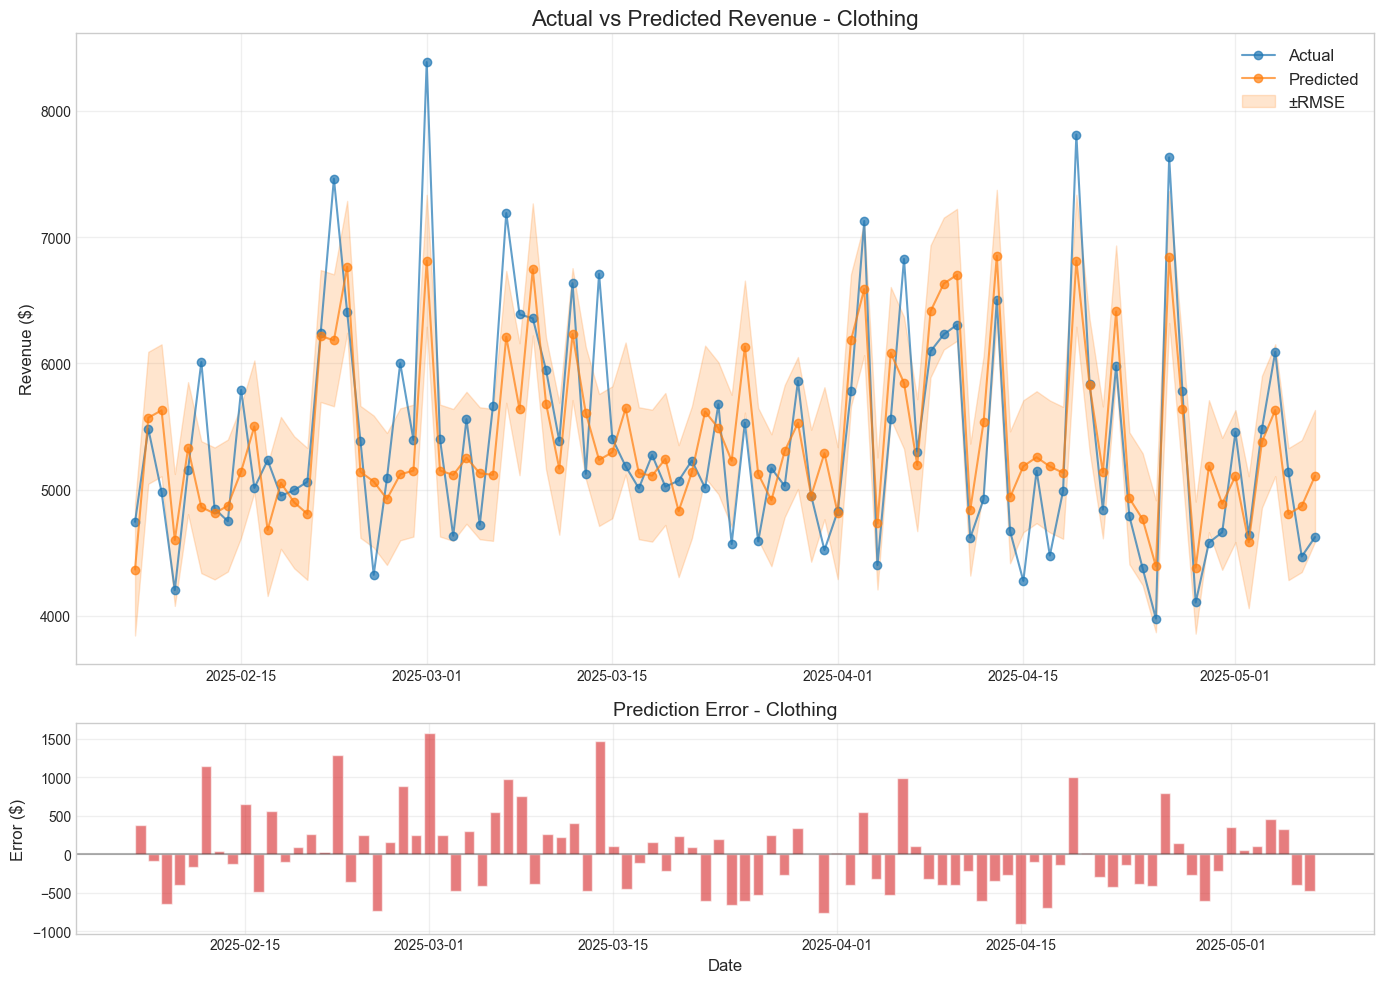

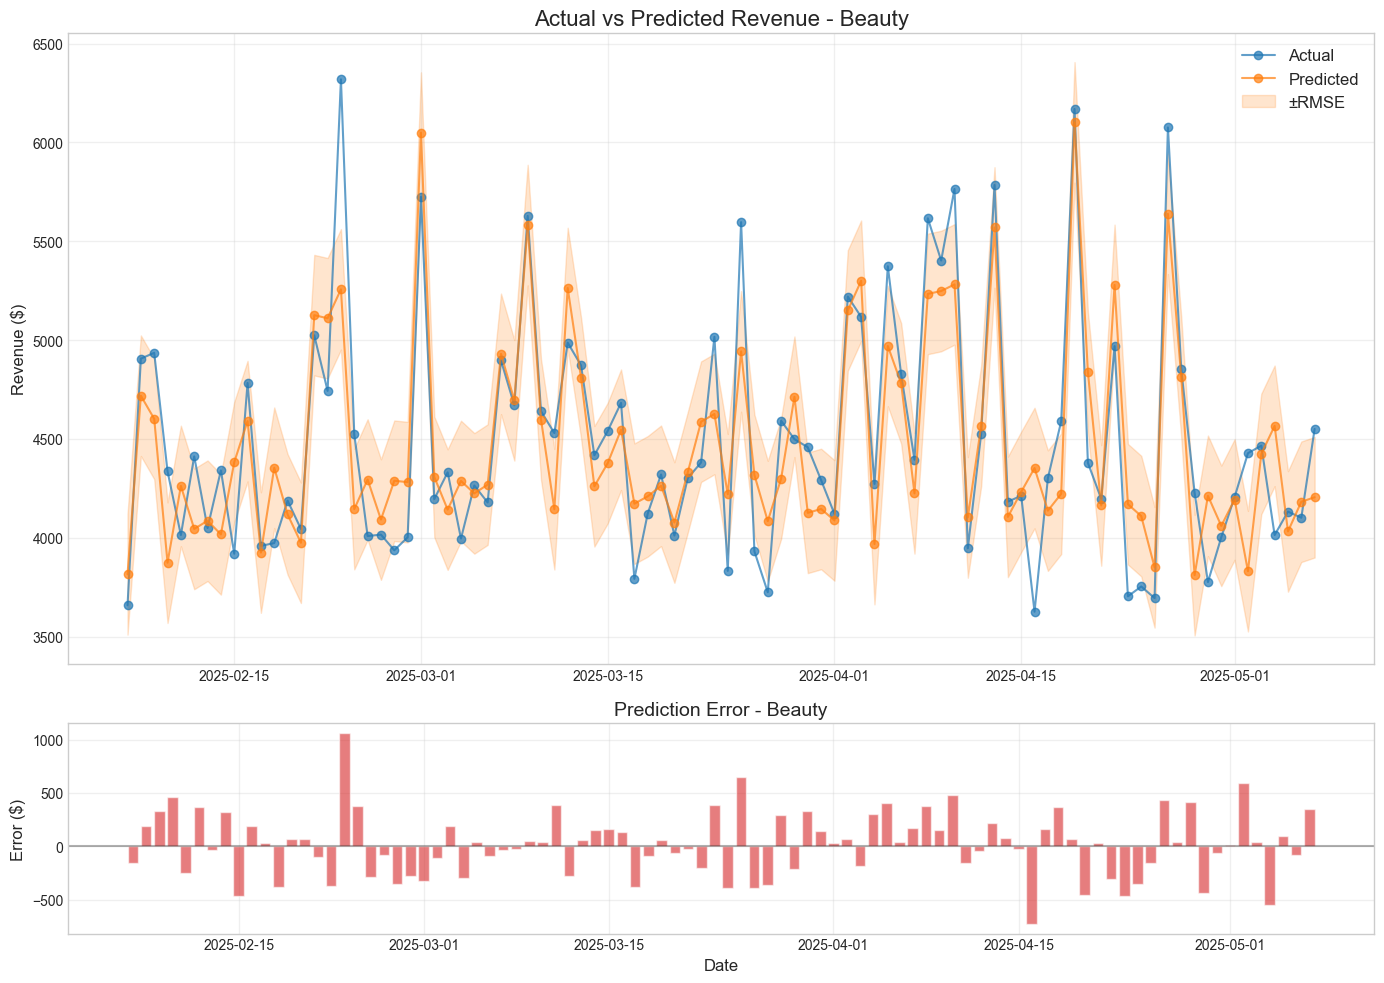

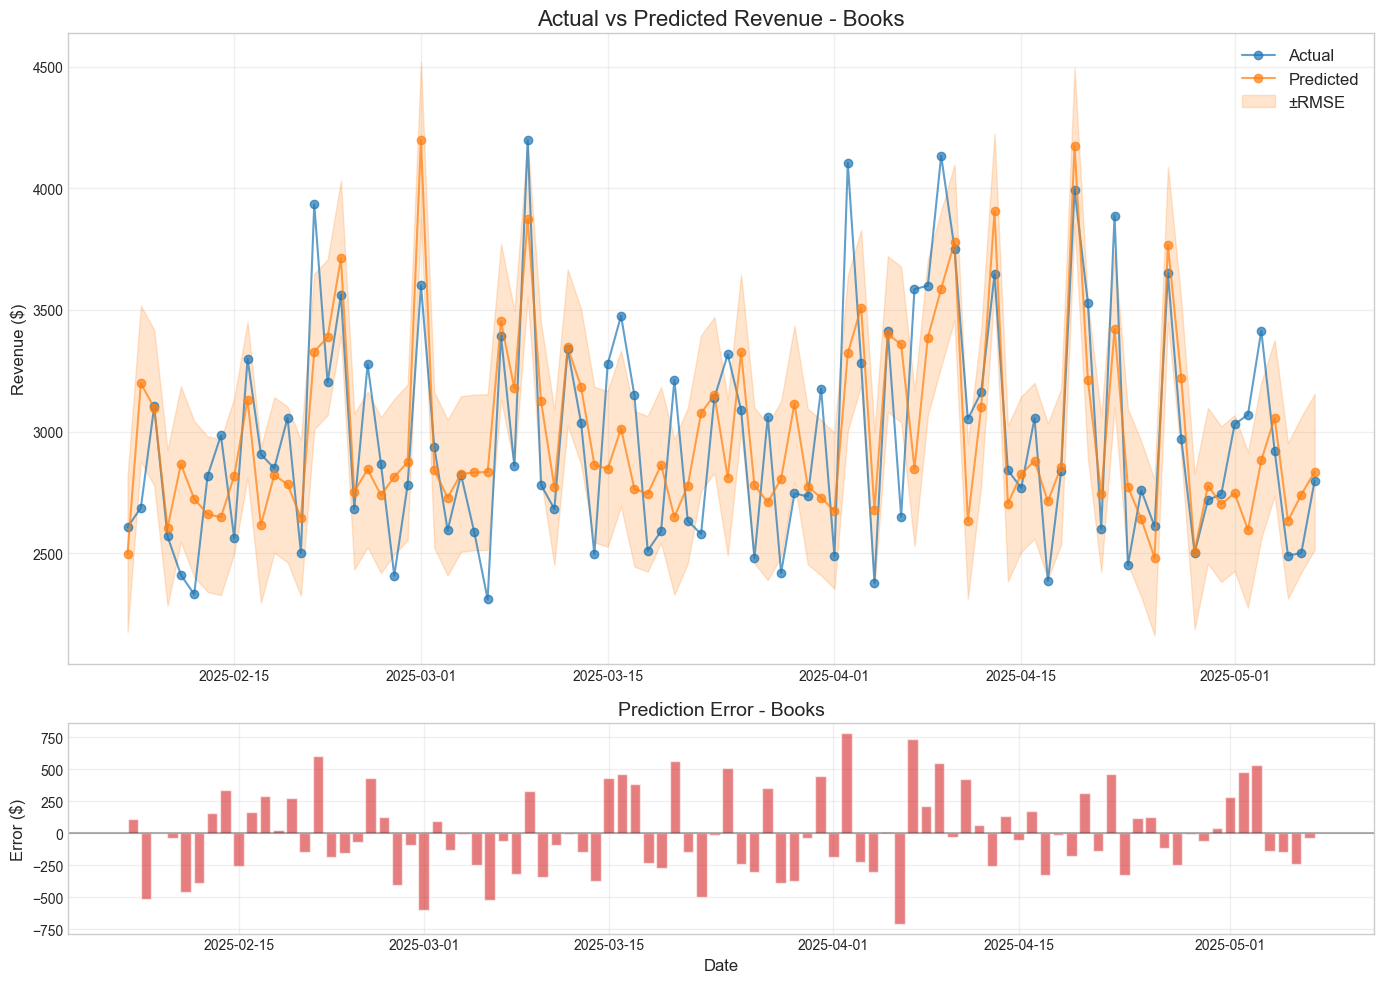

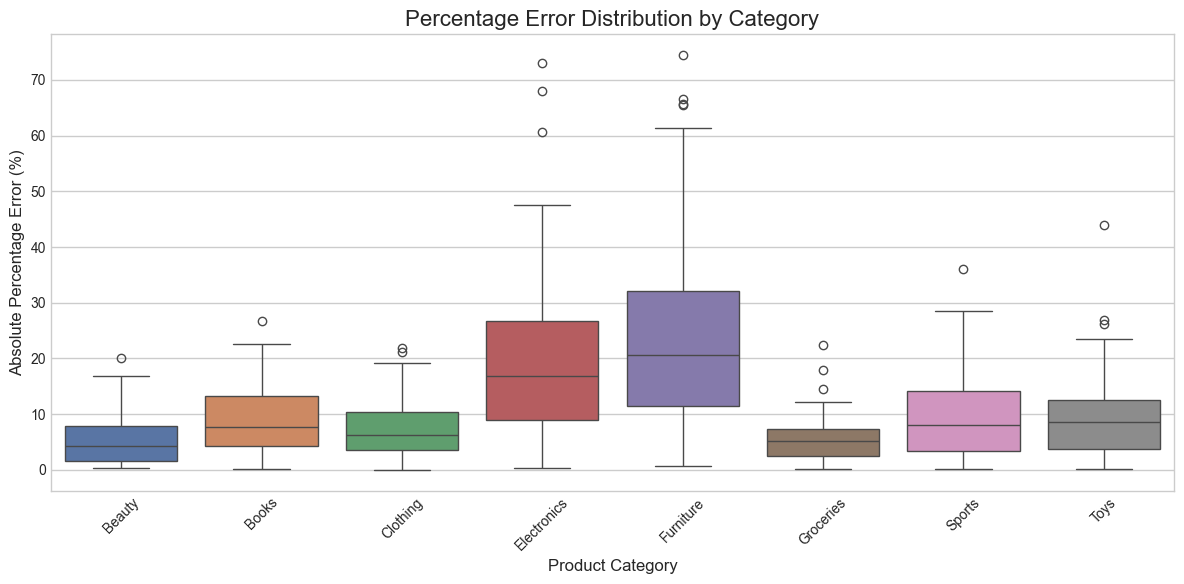

In [65]:
# Create DataFrames for actual and predicted values
pred_df = pd.DataFrame(preds, columns=y_test.columns, index=y_test.index)
actual_df = y_test.copy()

# Calculate error metrics for visualization
error_df = actual_df - pred_df
mape_df = (error_df.abs() / actual_df.abs()) * 100

# Get top categories by total sales volume
top_categories = actual_df.sum().sort_values(ascending=False).index[:3]
print(f"Visualizing predictions for top 3 categories by sales volume: {', '.join(top_categories)}")

# Set up a professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create time series plots for top categories
for i, category in enumerate(top_categories):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Plot 1: Actual vs Predicted
    ax1.plot(actual_df.index, actual_df[category], 'o-', color=colors[0], label='Actual', alpha=0.7)
    ax1.plot(pred_df.index, pred_df[category], 'o-', color=colors[1], label='Predicted', alpha=0.7)

    # Add confidence interval (simple approach - could be more sophisticated)
    rmse = np.sqrt(mean_squared_error(actual_df[category], pred_df[category]))
    ax1.fill_between(pred_df.index, 
                    pred_df[category] - rmse, 
                    pred_df[category] + rmse, 
                    color=colors[1], alpha=0.2, label='±RMSE')

    # Formatting
    ax1.set_title(f'Actual vs Predicted Revenue - {category}', fontsize=16)
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.legend(loc='best', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error Analysis
    ax2.bar(error_df.index, error_df[category], color=colors[3], alpha=0.6)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title(f'Prediction Error - {category}', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Error ($)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create a summary error plot for all categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=mape_df[mape_df < 100])  # Filter extreme outliers for better visualization
plt.title('Percentage Error Distribution by Category', fontsize=16)
plt.ylabel('Absolute Percentage Error (%)', fontsize=12)
plt.xlabel('Product Category', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Export for Production

In this section, we persist our trained model to disk so it can be used for future predictions without retraining. We save:

1. **The Trained Model**: The optimized algorithm with its learned parameters
2. **Feature Columns**: The exact features used during training to ensure consistent preprocessing
3. **Model Metadata**: Information about the model for documentation and versioning

This export process is a critical step in the machine learning workflow as it bridges the gap between model development and deployment, allowing our forecasting capabilities to be integrated into production systems.


In [66]:
# Save the best model and related artifacts
import pickle
import json
from datetime import datetime

# Create model directory if it doesn't exist
import os
os.makedirs('../model', exist_ok=True)

# Save the trained model
with open('../model/model.pkl', 'wb') as f:
    pickle.dump(final_model_info['model'], f)
    print(f"✓ Model saved to '../model/model.pkl'")

# Save feature columns for inference
with open('../model/feature_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)
    print(f"✓ Feature columns saved to '../model/feature_columns.pkl'")

# Create and save model metadata
model_metadata = {
    'model_type': final_model_info['model_name'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'test_rmse': float(final_model_info['Test_RMSE']),
        'cv_rmse': float(final_model_info['CV_RMSE']),
        'top1_accuracy': float(top_n_accuracy(y_test, preds, top_n=1)),
        'top3_accuracy': float(top_n_accuracy(y_test, preds, top_n=3))
    },
    'parameters': final_model_info['best_params'],
    'feature_count': len(X_train.columns),
    'training_samples': X_train.shape[0],
    'target_categories': target_cols
}

with open('../model/model_info.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
    print(f"✓ Model metadata saved to '../model/model_info.json'")

print("\nModel export completed successfully!")


✓ Model saved to '../model/model.pkl'
✓ Feature columns saved to '../model/feature_columns.pkl'
✓ Model metadata saved to '../model/model_info.json'

Model export completed successfully!


## Conclusion

In this notebook, we've successfully built and evaluated a robust sales forecasting system:

1. **Data Preparation**: We prepared our time series data with appropriate train-test splitting to simulate real-world forecasting scenarios.

2. **Model Comparison**: We evaluated multiple machine learning algorithms (XGBoost, LightGBM, CatBoost, and Random Forest) and identified the best performer for our specific forecasting task.

3. **Hyperparameter Tuning**: We optimized the model parameters to achieve the best possible forecasting accuracy.

4. **Performance Evaluation**: We assessed model performance using multiple metrics including RMSE, category-specific errors, and top-N accuracy.

5. **Model Export**: We saved the trained model and necessary artifacts for production deployment.

The final model can now be used in the next notebook for inference and integration into the QuickBooks forecasting system. This forecasting capability will provide valuable insights to help businesses make data-driven decisions about inventory management, staffing, and financial planning.
